In [1]:
!pip install transformers datasets torch scikit-learn pandas wordcloud

In [2]:
from datasets import load_dataset

# Load SST5 dataset
sst5_dataset = load_dataset("SetFit/sst5")
train_data = sst5_dataset["train"]
train_data[0]

Repo card metadata block was not found. Setting CardData to empty.


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 4,
 'label_text': 'very positive'}

In [3]:
twitter_dataset = load_dataset("tweet_eval", "sentiment")
twt_train_data = twitter_dataset["train"]
twt_train_data[0]

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 'label': 2}

In [4]:
print(sst5_dataset)
print(sst5_dataset["train"].column_names)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})
['text', 'label', 'label_text']


In [5]:
print(twitter_dataset)
print(twitter_dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
['text', 'label']


In [6]:
def convert_sst5(example):
    label = int(example["label"])
    # label = example["label"]
    if label in [0, 1]:
        return {"text": example["text"], "label": 0}
    elif label == 2:
        return {"text": example["text"], "label": 1}
    else:
        return {"text": example["text"], "label": 2}

# sst5_mapped = sst5_dataset.map(convert_sst5)
sst5_mapped = sst5_dataset.map(convert_sst5, remove_columns=["label_text"])
print(sst5_mapped["train"][0])
print(sst5_dataset["train"][0])


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 2}
{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive'}


In [7]:
from datasets import DatasetDict, Value

def convert_twitter(example):
    return {"text": example["text"], "label": int(example["label"])}


twitter_mapped = twitter_dataset.map(convert_twitter)
print(twitter_mapped["train"][0])

# Force label column to be int64 instead of ClassLabel

# twitter_mapped = DatasetDict({
#     split: ds.cast_column("label", Value("int64"))
#     for split, ds in twitter_dataset.items()
# })



{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [8]:
from datasets import concatenate_datasets, DatasetDict
from datasets import ClassLabel

# Define common ClassLabel
label_class = ClassLabel(names=["negative", "neutral", "positive"])

# Ensure label columns are the same type before combining
sst5_mapped = sst5_mapped.cast_column("label", label_class)
twitter_mapped = twitter_mapped.cast_column("label", label_class)

full_combined_dataset = concatenate_datasets([
    sst5_mapped["train"], 
    sst5_mapped["test"], 
    twitter_mapped["train"], 
    twitter_mapped["test"],
    sst5_mapped["validation"], 
    twitter_mapped["validation"]
    
])

# Shuffled
full_combined_dataset = full_combined_dataset.shuffle(seed=42)




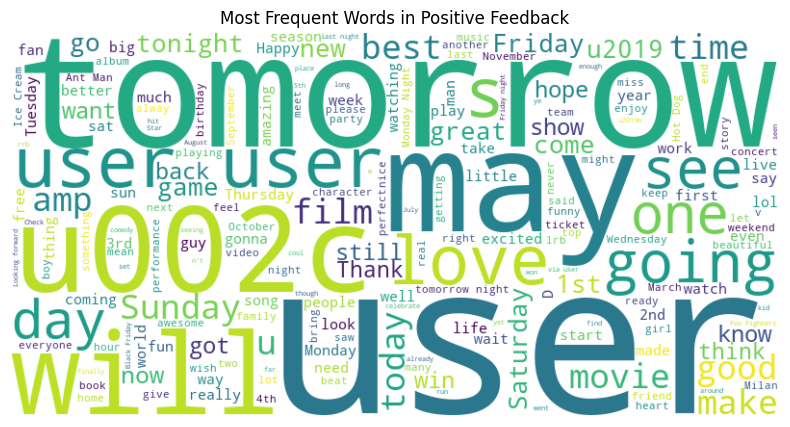

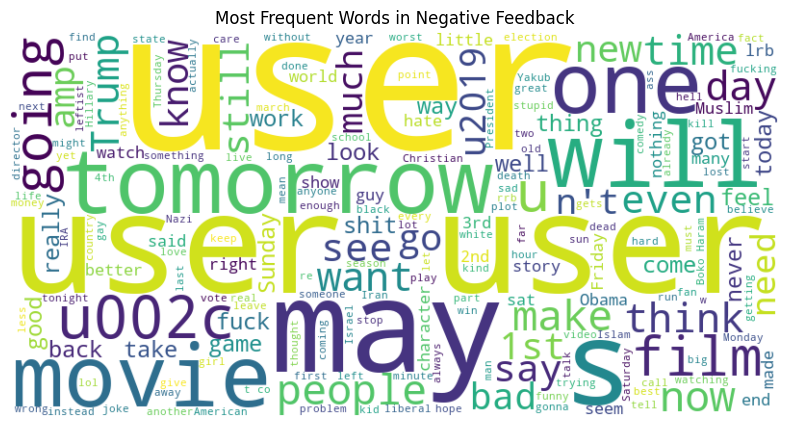

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative texts using .filter()
positive_examples = full_combined_dataset.filter(lambda x: x["label"] == 2)
negative_examples = full_combined_dataset.filter(lambda x: x["label"] == 0)

# Join all texts into a single string
positive_texts = " ".join(positive_examples["text"])
negative_texts = " ".join(negative_examples["text"])

# WordCloud for positive feedback
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Feedback")
plt.show()

# WordCloud for negative feedback
wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Feedback")
plt.show()


In [10]:
# Split the combined dataset (80% train, 20% test)
combined_dataset = full_combined_dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="label"  # makes sure all labels are balanced
)

combined_train = combined_dataset["train"]
combined_test = combined_dataset["test"]

In [11]:
import re
import string

def clean_text(combined_train):
    combined_train = combined_train.lower()
    combined_train = re.sub(r"http\S+|www\S+|https\S+", '', combined_train, flags=re.MULTILINE)  # Remove URLs
    combined_train = re.sub(r'\@\w+|\#', '', combined_train)  # Remove @mentions and hashtags
    combined_train = combined_train.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    combined_train = re.sub(r'\d+', '', combined_train)  # Remove digits
    combined_train = re.sub(r'\s+', ' ', combined_train).strip()  # Remove extra whitespaces
    return combined_train


In [12]:
from collections import Counter

label_counts = Counter(combined_train['label'])
print(label_counts)


Counter({1: 23777, 2: 20805, 0: 12821})


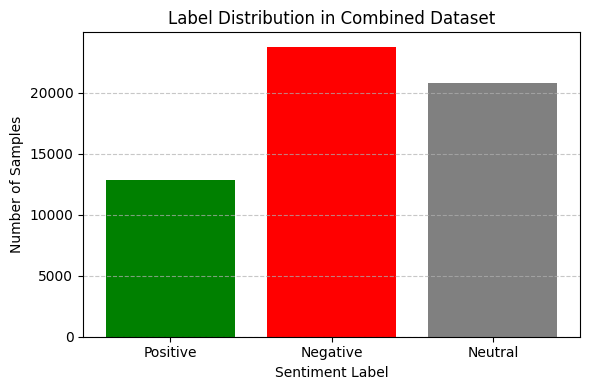

In [ ]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# names for readability
label_names = ['Negative', 'Positive', 'Neutral']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, tick_label=label_names, color=['red', 'gray', 'green'])
plt.title("Label Distribution in Combined Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Load tokenizer and model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


# Tokenize data
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train,
    eval_dataset=combined_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()



In [16]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model_LR= LogisticRegression()
model_DT= DecisionTreeClassifier()
model_RF= RandomForestClassifier()
model_GNB= GaussianNB()

X_train = tokenized_datasets_train["text"]
y_train = tokenized_datasets_train["label"]
X_test = tokenized_datasets_test["text"]
y_test = tokenized_datasets_test["label"]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
# y_train = vectorizer.fit_transform(y_train)
# y_test = vectorizer.transform(y_test)


model_LR.fit(X_train, y_train)
model_DT.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
# model_GNB.fit(X_train, y_train)

predicted_LR = model_LR.predict(X_test)
predicted_DT = model_DT.predict(X_test)
predicted_RF = model_RF.predict(X_test)
# predicted_GNB = model_GNB.predict(X_test)

accuracy_LR = accuracy_score(y_test, predicted_LR)
accuracy_DT = accuracy_score(y_test, predicted_DT)
accuracy_RF = accuracy_score(y_test, predicted_RF)
# accuracy_GNB = accuracy_score(y_test, predicted_GNB)

print(f"Logistic Regression Accuracy: {accuracy_LR:.4f}")
print(f"Decision Tree Accuracy: {accuracy_DT:.4f}")
print(f"Random Forest Accuracy: {accuracy_RF:.4f}")
# print(f"Gaussian Naive Bayes Accuracy: {accuracy_GNB:.4f}")

Map:   0%|          | 0/57403 [00:00<?, ? examples/s]

Map:   0%|          | 0/14351 [00:00<?, ? examples/s]

c:\Users\shada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6417
Decision Tree Accuracy: 0.5329
Random Forest Accuracy: 0.6076


In [17]:
from sklearn.naive_bayes import GaussianNB

# Initialize the model
model_GNB = GaussianNB()

# Convert sparse matrix to dense only for GaussianNB
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Fit the model
model_GNB.fit(X_train_dense, y_train)

# Evaluate
predicted_GNB = model_GNB.predict(X_test_dense)
print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test, predicted_GNB))


Gaussian Naive Bayes Accuracy: 0.4755766148700439


In [ ]:
from sklearn.svm import SVC

model_SVC = SVC(kernel='linear', probability=True)

model_SVC.fit(X_train_dense, y_train)
predicted_SVC = model_SVC.predict(X_test_dense)
print("SVC Accuracy:", accuracy_score(y_test, predicted_SVC))


In [ ]:
trainer.evaluate()


In [ ]:
# Save the trained model
model.save_pretrained("initialModel")
tokenizer.save_pretrained("initialModel")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer
model_path = "./initialModel"  # or the path where you saved it
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

# Set to evaluation mode (important for inference)
model.eval()

In [ ]:
test_sentences = [
    "The teacher explained everything clearly.",
    "The class was ok",
    "The course was too fast and confusing.",
    "I loved the way topics were discussed."
]

# Tokenize input
inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=-1)

print(predictions)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
def classify_feedback(feedback):
    inputs = tokenizer(feedback, padding=True, truncation=True, return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)
    return predictions

In [ ]:
from keybert import KeyBERT

kw_model = KeyBERT(model="distilbert-base-nli-mean-tokens")

feedback = [
    "The lectures were interesting but the assignments were too difficult.",
    "I liked the interactive sessions but the notes were missing details."
]

for fb in feedback:
    keywords = kw_model.extract_keywords(fb, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=3)
    print(f"Feedback: {fb}\nKeywords: {keywords}\n")


In [ ]:
labels = ["Negative", "Neutral", "Positive"]
result = classify_feedback(["This class was fun"])
print("Prediction:", labels[result[0].item()])
print(result)
